# A joint multilevel model for CAR 
Using MVS.CARLeroux
## Common Markov Gaussian Random Field
 $$ [P , S ] = [P | GMRF] [ S | GMRF] $$

In [263]:
## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')

In [264]:
rm(list=ls())                                                                                     
source("init_data.R")                                                                             
# load the building function                                                                      
#source("joint.binomial.bymCAR.R")

S <- model.frame(formula_sample, DataFrame,na.action='na.pass')
P <- model.frame(formula_presence, DataFrame,,na.action='na.pass')

In [265]:
SX <- select(S, -c(1))
PX <- select(P, -c(1))
Sy <- select(S, c(1))
Py <- select(P, c(1))

names(Sy) <- 'response'
names(Py) <- names(Sy)
Y = rbind(Sy,Py)

### Let's build covariance matrix
T1 <- matrix(rep(0,4), ncol = 2)
T2 <- matrix(rep(0,4), ncol = 2)
T1[1,1] <- 1
T2[2,2] <- 1

X <- data.frame((T1 %x% as.matrix(SX)) + (T2 %x% as.matrix(PX)))
names(X) <- c(names(SX),names(PX))

DD <- cbind(Y,X)

nK <- dim(M_bis)[1]
ida <- data.frame(seq(nK))
idarea <- unlist(rbind(ida,ida))

corx <- rep(x = 1,times = nK)
cory <- rep(x = 2,times = nK)

indre <- c(corx,cory)

formula <- response ~ Disttoroadm + Populationm + Elevationm + MeanTempm

In [ ]:
## now, assuming that the order in M_bis is the same as in cellids (OOOORDEEER, not value)
## Run the model
trials = rep(1,2 * nK)
burnin = 100000
n.sample = 200000
thin = 5
model2 <- S.CARmultilevel(formula,family = 'binomial',
                          trials=trials, 
                          W=M_bis, 
                          ind.area = idarea,
                         ind.re=NULL,
                          rho = 1,
                          burnin = burnin,
                          n.sample = n.sample,
                          data = DD
                         )

Setting up the model.
There are no individual level effects in this model
Generating 1e+05 post burnin and thinned (if requested) samples.
  |=                                                                     |   1%

In [ ]:
### Notas
## El postburnin es una mamada, quitar

n.sample = 20000
burnin= 10000
single_burnin = 1
postburnin = 2    
thin = 10
verbose = TRUE
c <- 1.001 # 
fixed_prior_gamma_shape_tau <- 1
prior_tau_scale <- 0.01
prior_sigma_scale <- 0.01
fixed_prior_gamma_shape_sigma <- 1

results  <- joint.binomial.bymCARModel2(formula_S = formula_sample, 
                                        formula_P = formula_presence,
                                        n.sample=n.sample,
                                        burnin=burnin,
                                        single_burnin=single_burnin,
                                        postburnin=postburnin,
                                        thin=thin,
                                        verbose=TRUE,
                                       prior.tau2=c(fixed_prior_gamma_shape_tau,prior_tau_scale),
                                       prior.sigma2=c(fixed_prior_gamma_shape_sigma,prior_sigma_scale),
                                        tau2_sigma2_denominator=c,
                                       #prior.tau2=c(0.1,1),
                                       #prior.sigma2=c(0.1,1),
                                       data = DataFrame)
                                       #data = rr)

## I put 5 ceros

## Remember to check likelihood modelfit

In [ ]:
#Change priors tau2 and sigma2
#0.1 , 0.01


In [ ]:
model2$modelfit

In [ ]:
model2$summary.results

## Some plots and analysis for convergence


In [ ]:
library(coda)

## $\tau^{2}$

In [ ]:
plot(model2$samples$tau2)
#plot(results$ind.model.S$model.results$samples$tau2)
#plot(results$ind.model.P$model.results$samples$tau2)

## $\sigma^2$

In [ ]:
model2$samples$sigma2[2]
#plot(results$ind.model.S$model.results$samples$sigma2)
#plot(results$ind.model.P$model.results$samples$sigma2)

## $\beta$

In [ ]:
plot(model2$samples$beta)

#plot(results$ind.model.S$model.results$samples$tau2)
#plot(results$ind.model.P$model.results$samples$tau2)

## Diagnostics, Mr. Gelmans, et.al

In [ ]:
post.sample_p = data.frame(model2$samples$fitted)

## Sample the posterior 

In [ ]:
pss  <- post.sample_p %>% mutate_all(function(p) rbernoulli(1,p))
                                        

In [ ]:
## divide samples for S and P according to the order given up
pred.S <- pss[,1:nK]
pred.P <- pss[,(nK +1) : (2*nK) ]


In [ ]:
sumpss <- colSums(pred.S)

In [ ]:
prob_pss <- sumpss / length(pred.S)

In [ ]:
sumpps <- colSums(pred.P)

In [ ]:
prob_pps <- sumpps / length(pred.P)

In [ ]:
probpres = prob_pps * prob_pss

In [ ]:
## plot TDF$cells to see if its order
plot(TDF$cellids)

In [ ]:
chain = cbind(TDF$cellids,probpres,prob_pps,prob_pss)
file_ = '/outputs/presence_only_models/modelCAR_model2_fitted_multilevel.csv'
write.csv(chain,file_)

## Posterior análisis with a varying C $\tau^2, \sigma^2$ denominator

In [609]:
# Read the file
bfile = '/outputs/presence_only_models/joint-model2-benchmark-denominator.csv'
res <- read.csv(bfile)

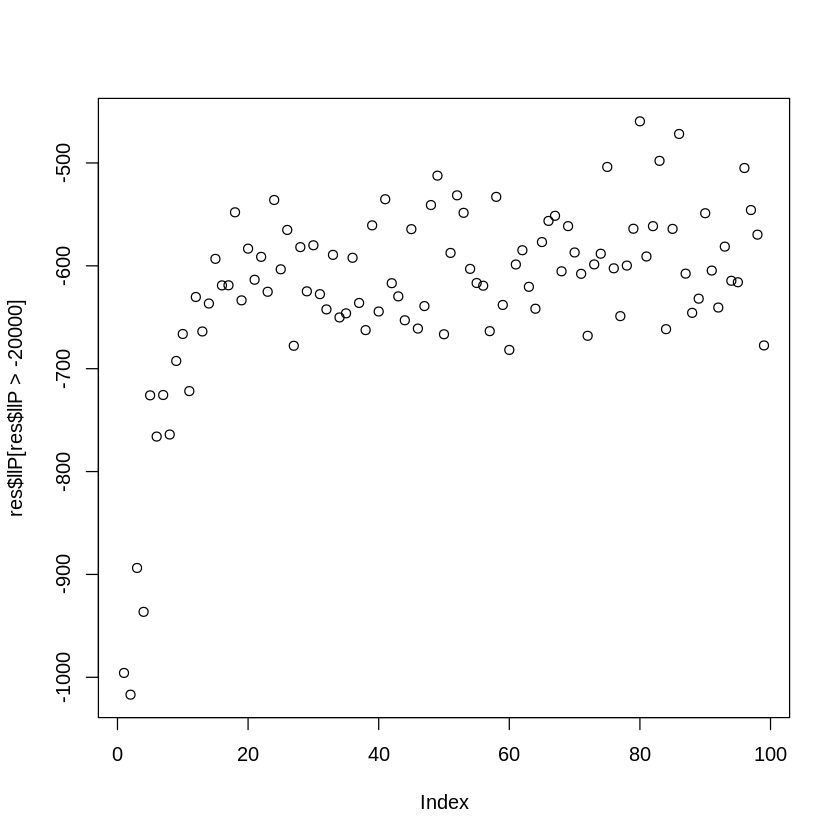